In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib
import re
import time
import itertools
import seaborn
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
seaborn.set(style='ticks',font_scale=2)

# List of directed graphs with degree 2 and 9 vertices 

In [587]:
poke_pos = [  [265,456],
         [184,475],[347,475],
    [116,518],[265,518],[414,518],
         [184,561],[347,561],
              [265,580]]

In [600]:
poke_pos = [  [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [589]:
[np.array(i)-np.array([116,456]) for i in poke_pos]

[array([149,   0]),
 array([68, 19]),
 array([231,  19]),
 array([ 0, 62]),
 array([149,  62]),
 array([298,  62]),
 array([ 68, 105]),
 array([231, 105]),
 array([149, 124])]

In [415]:
poke_pos = np.array([[8,10],
                    [7,8],[9,8],
                    [6,6],[8,6],[10,6],
                    [7,4],[9,4],
                    [8,2]])


poke_posN = poke_pos.copy()
poke_posN[:,0] -= 8
poke_posN[:,1] -= 6 

In [367]:
with open('/Users/Yves/Downloads/yvestest','r') as f:
    graphs = f.readlines()

In [368]:
def to_gunnar_graph(g_spec):
    "convert output of gunnar algorithm to list of list of edges"
    
    
    nVert,nEdge = g_spec.split(' ')[:2]
    #links = [int(i) for i in g_spec[5:-3].split(' ')]
    links = [int(i) for i in re.findall('[0-9]',g_spec[5:])]

    edges = []
    edge_set = np.zeros([9,2],dtype='int')
    cntArr = np.zeros(9,dtype='int')
    for fst,snd in zip(links[:-1][::2],links[1:][::2]):
        edges.append([fst,snd])
        edge_set[fst,cntArr[fst]] = snd
        cntArr[fst] += 1
    return edges,edge_set

In [369]:
possible_reward_locations = list(itertools.combinations(range(9),4))

In [11]:
#%%timeit
nGraphs = 0
use_ixs = []
for graph_ix in range(len(graphs)):
    g = nx.DiGraph()
    g.add_edges_from(to_gunnar_graph(graphs[graph_ix])[0])
    if len(list(nx.strongly_connected_components(g)))==1:
        nGraphs += 1
        use_ixs.append(graph_ix)
    else:
        pass

In [568]:
def value_iteration(world, g=.01):
    '''Evaluate state values under the optimal policy for specified world and 
    discount factor g.'''
    d = 1.                       # Value change
    V = np.zeros(world.n_states) # Value estimate.
    while d > 1e-12:
        prev_V = V[:].copy()
        #this this line of V
        #V = np.max(np.sum(world.trans_mat * (world.rewards + g*V)[None,None,:],2),1)
        V = np.max(np.mean((gw.trans_mat * (gw.rewards + g*V)),2),1)
        print(V)
        d = np.max(np.abs(prev_V-V))
    Q = world.trans_mat @ (world.rewards + g*V)  # Action values.
    policy = (Q == np.max(Q,1)[:,None]).astype(float)
    policy = policy/np.sum(policy,1)[:,None]
    return V, Q, policy

In [178]:
class graphworld(object):
    """ To do list:
            incorporate the random transitions
            make the final state absorbing
    """
    def __init__(self,graph_spec,nNodes=9,nActions=2,teleport_probability=.0,build_nx_graph=False):
        
        self.graph_spec = graph_spec
        self.edges, self.edge_transitions = self.read_gunnar_graph(self.graph_spec)

        self.terminal_states = []
        self.rewards = np.zeros(self.nNodes)
        self.teleport_probability = teleport_probability
        self.build_trans_mat()
        
        if build_nx_graph:
            self.G = nx.DiGraph()
            self.G.add_edges_from(gw.edges)

        
    def set_reward_state(self,nodeNr,terminal=False):
        "right now handles setting one state as the rewarded one"
        assert (nodeNr<= self.nNodes)
        
        #reinitialise
        self.rewards = np.zeros(self.nNodes)
        self.terminal_states = []
        
        #set values
        self.rewards[nodeNr] = 1.
        if terminal:
            self.terminal_states.append(nodeNr)
        self.build_trans_mat()

    def read_gunnar_graph(self,g_spec):
        """convert output of gunnar algorithm to list of list of edges
            as well as a matrix defining the transitions as a function
            of actions
        """


        nNodes,nEdges = g_spec.split(' ')[:2]
        self.nNodes = self.n_states = int(nNodes)
        self.nEdges = int(nEdges)
        self.nActions = int(float(nEdges)/float(nNodes))
        #print(self.nActions,self.nNodes)

        links = [int(i) for i in re.findall('[0-9]',g_spec[5:])]

        edges = []
        edge_set = np.zeros([self.nNodes,self.nActions],dtype='int')
        cntArr = np.zeros(self.nNodes,dtype='int')
        for fst,snd in zip(links[:-1][::2],links[1:][::2]):
            edges.append([fst,snd])
            edge_set[fst,cntArr[fst]] = snd
            cntArr[fst] += 1
        return edges,edge_set

    def build_trans_mat(self):
        self.trans_mat = np.zeros([self.nNodes,self.nActions,self.nNodes]) + self.teleport_probability/(self.nNodes-1.)
        for s in range(self.nNodes):
            if not s in self.terminal_states:
                for a in range(self.nActions):
                    self.trans_mat[s,a,self.edge_transitions[s,a]] = 1 - self.teleport_probability
            else:
                self.trans_mat[s] = 0
                
    def plot_policy_onto_graph(self,P,pos=None):
        
        self.G = nx.DiGraph()
        self.G.add_edges_from(gw.edges)

        colors = self._get_edge_colors(P)
        nx.draw(self.G,pos=pos,with_labels=True,edge_color=colors)
    
    def build_nx_graph(self):
        self.G = nx.DiGraph()
        self.G.add_edges_from(gw.edges)

        
    def _get_edge_colors(self,P):
        #What we want to do here is to 
        colors = ['k']*len(self.edges)
        for stateIx in range(self.n_states):
            p_ = P[stateIx]
            if p_[0]!=p_[1]:
                goodMove = np.argmax(p_)
                badMove = np.argmin(p_)

                good_edge = [stateIx,self.edge_transitions[stateIx,goodMove]]
                bad_edge = [stateIx,self.edge_transitions[stateIx,badMove]]

                good_edge_ix = [kk for kk,i in enumerate(self.G.edges) if list(i)==good_edge][0]
                bad_edge_ix = [kk  for kk,i in enumerate(self.G.edges) if list(i)==bad_edge][0]
                #print(good_edge,good_edge_ix)

                colors[good_edge_ix] = 'g'
                colors[bad_edge_ix] = 'r'
        return colors

In [532]:
from functools import lru_cache


In [540]:
@lru_cache(None)
def value_iteration(world, g=.9):
    '''Evaluate state values under the optimal policy for specified world and 
    discount factor g.'''
    d = 1.                       # Value change
    V = np.zeros(world.n_states) # Value estimate.
    while d > 1e-12:
        prev_V = V[:].copy()
        #this this line of V
        V = np.max(np.sum(world.trans_mat * (world.rewards + g*V)[None,None,:],2),1)
        d = np.max(np.abs(prev_V-V))
    Q = world.trans_mat @ (world.rewards + g*V)  # Action values.
    policy = (Q == np.max(Q,1)[:,None]).astype(float)
    policy = policy/np.sum(policy,1)[:,None]
    return V, Q, policy

In [541]:
def value_iteration2(world, g=.9):
    '''Evaluate state values under the optimal policy for specified world and 
    discount factor g.'''
    d = 1.                       # Value change
    V = np.zeros(world.n_states) # Value estimate.
    while d > 1e-12:
        prev_V = V[:].copy()
        #this this line of V
        V = np.max(np.sum(world.trans_mat * (world.rewards + g*V)[None,None,:],2),1)
        d = np.max(np.abs(prev_V-V))
    Q = world.trans_mat @ (world.rewards + g*V)  # Action values.
    policy = (Q == np.max(Q,1)[:,None]).astype(float)
    policy = policy/np.sum(policy,1)[:,None]
    return V, Q, policy

In [547]:
st = time.time()
V,Q,P = value_iteration(gw)
print(time.time() - st)

0.0001010894775390625


In [548]:
st = time.time()
V2,Q2,P2 = value_iteration2(gw)
print(time.time() - st)

0.017881155014038086


In [549]:
Q==Q2

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

# Test on a single example 

In [106]:
graph_ix = 24

In [71]:
gw = graphworld(graph_spec=graphs[use_ixs[graph_ix]])
gw.set_reward_state(5)

In [247]:
gw.edges

[[0, 1],
 [0, 3],
 [1, 0],
 [1, 3],
 [2, 0],
 [2, 1],
 [3, 4],
 [3, 7],
 [4, 2],
 [4, 6],
 [5, 2],
 [5, 4],
 [6, 7],
 [6, 8],
 [7, 5],
 [7, 8],
 [8, 6],
 [8, 5]]

In [ ]:
__format__

In [72]:
#%%timeit
V,Q,P = value_iteration(gw)

In [73]:
P

array([[0. , 1. ],
       [0. , 1. ],
       [0.5, 0.5],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ]])

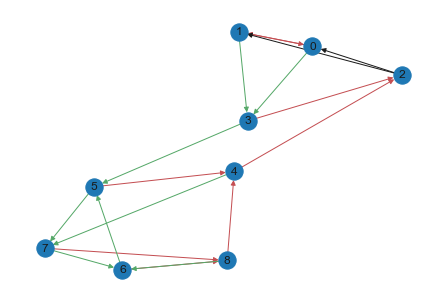

In [74]:
gw.plot_policy_onto_graph(P)

In [289]:
factorial(4)

array(24.)

In [75]:
planars = []
avG_shortest_path_lengths = []
for graph_ix in use_ixs:
    g = nx.DiGraph()
    g.add_edges_from(to_gunnar_graph(graphs[graph_ix])[0])
    avG_shortest_path_lengths.append(nx.average_shortest_path_length(g))
    planars.append(nx.algorithms.planarity.check_planarity(g)[0])

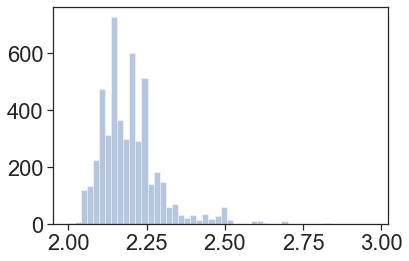

In [76]:
seaborn.distplot(avG_shortest_path_lengths,kde=0)

In [183]:
st = time.time()
allV = []
allQ = []
allP = []
allLD = []

possible_reward_locations = list(itertools.combinations(range(9),4))



for graph_ix in use_ixs[50:100]:
    
    gw = graphworld(graphs[graph_ix])
    
    for rsetNr,rSet in enumerate(possible_reward_locations):
        tmpV = []
        tmpP = []
        tmpQ = []
        tmpLD = []
        for r in rSet:
            gw.set_reward_state(r)    
            V,Q,P = value_iteration(gw)
            tmpV.append(V.copy())
            tmpP.append(P.copy())
            tmpQ.append(Q.copy())
            tmpLD.append(find_shortest_reward_loop(gw).copy())
        allV.append([graph_ix,rsetNr,tmpV.copy()])
        allP.append([graph_ix,rsetNr,tmpP.copy()])
        allQ.append([graph_ix,rsetNr,tmpQ.copy()])
        allLD.append([graph_ix,rsetNr,tmpLD.copy()])
print(time.time() - st)

KeyboardInterrupt: 

In [226]:
gIxs = []
for i in range(len(allLD)):
    #if np.sum(np.array(allLD[i][-1])>1)>2:
    #    gIxs.append(i)
    if np.sum(np.array(allLD[i][-1]))>=9:
        gIxs.append(i)

In [227]:
pairs = list(itertools.combinations(range(4),2))

In [228]:
diffStore = []
for kk,tmpP in enumerate(allP):
    if kk in gIxs:
        tmpa = [i.flatten() for i in tmpP[-1]]
        diffs = []
        for pair in pairs:
            diffs.append(np.sum(np.abs(tmpa[pair[0]]-tmpa[pair[1]])))

        diffStore.append(np.mean(diffs))
    else:
        diffStore.append(-10)

In [229]:
np.argmax(np.array(diffStore)[gIxs])

157

In [230]:
len(diffStore)

4977

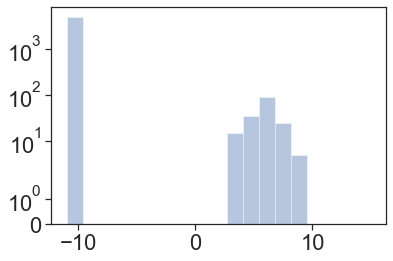

In [231]:
seaborn.distplot(diffStore,kde=0,bins=np.linspace(-11,15,num=20))
plt.yscale('symlog')

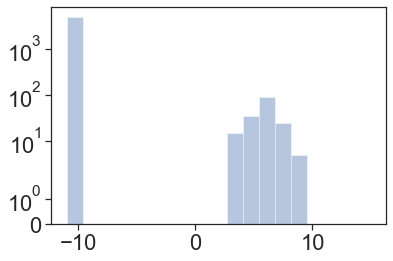

In [232]:
seaborn.distplot(diffStore,kde=0,bins=np.linspace(-11,15,num=20))
plt.yscale('symlog')

In [233]:
np.max(diffStore)

9.0

In [234]:
gw = graphworld(graphs[allV[np.argmax(diffStore)][0]])
possible_reward_locations[allV[np.argmax(diffStore)][1]]

(0, 2, 5, 7)

In [246]:
gw.edges

[[0, 1],
 [0, 3],
 [1, 0],
 [1, 3],
 [2, 0],
 [2, 1],
 [3, 4],
 [3, 7],
 [4, 2],
 [4, 6],
 [5, 2],
 [5, 4],
 [6, 7],
 [6, 8],
 [7, 5],
 [7, 8],
 [8, 6],
 [8, 5]]

In [235]:
gw.set_reward_state(1)

In [236]:
V,Q,P = value_iteration(gw)


In [237]:
def find_shortest_reward_loop(gw):
    """ Find the shortest loop back to reward """
    if not hasattr(gw,'G'):
        gw.build_nx_graph()
    rewIx = int(np.where(gw.rewards)[0])
    t1,t2 = gw.edge_transitions[rewIx]
    shortest_path = np.min([nx.shortest_path_length(gw.G,source=t1,target=rewIx),
                            nx.shortest_path_length(gw.G,source=t2,target=rewIx)])
    return shortest_path

In [238]:
gw.build_nx_graph()

In [265]:
from scipy.special import factorial

In [364]:
def find_physical_edge_lengths(edges,pos):
    """ This function takes in the edges of the
        graph as well as the physical position of
        the nodes and returns the distribution of
        physical distances between nodes
    """
    pos = np.array(pos).astype('float')
    
    dists = []
    for edge in edges:
        dists.append(np.sum(np.abs(pos[edge[0]],pos[edge[1]])))
    return np.array(dists)

In [373]:
all_orders = get_all_valid_physical_layouts(rew_nodes,9)

In [375]:
np.array(poke_pos)[all_orders[0]]

array([[ 8, 10],
       [ 7,  8],
       [ 6,  6],
       [ 9,  8],
       [ 8,  6],
       [10,  6],
       [ 7,  4],
       [ 8,  2],
       [ 9,  4]])

In [379]:
edge_lengths = []
for ordr in all_orders:
    edge_lengths.append(find_physical_edge_lengths(gw.edges,np.array(poke_pos)[ordr]))

In [395]:
np.array(poke_pos)[all_orders[0]]

array([[ 8, 10],
       [ 7,  8],
       [ 6,  6],
       [ 9,  8],
       [ 8,  6],
       [10,  6],
       [ 7,  4],
       [ 8,  2],
       [ 9,  4]])

In [389]:
mads = []
for eL in edge_lengths:
    mads.append(np.max([abs(a -b) for a, b in itertools.combinations(eL, 2)]) -
                np.min([abs(a -b) for a, b in itertools.combinations(eL, 2)]))


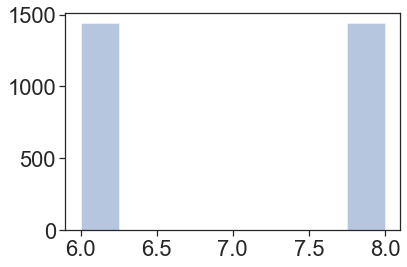

In [391]:
seaborn.distplot(mads,kde=0)

In [347]:
def get_all_valid_physical_layouts(rew_nodes,nNodes):
    
    """ Takes props of graph and returns all possible permutations of node locations
        respecting that rewards should be at the edges
        
        Checked by making sure rewards stay at edges and outputs are unique
    """
    
    Rlocs = np.array([0,3,5,8])
    Rmaps = list(itertools.permutations(rew_nodes))
    
    
    nonRlocs = np.array([i for i in range(9) if i not in Rlocs])
    nonR = [i for i in range(nNodes) if i not in rew_nodes]
    nonR_maps = list(itertools.permutations(nonR))
    
    orders = []
    
    for rMap in Rmaps:
        
        for nrMap in nonR_maps:
            
            order = np.zeros(nNodes)
            order[np.array(rMap)] = Rlocs

            order[np.array(nrMap)] = nonRlocs
            
            orders.append(order.copy().astype('int'))
    
    return orders

In [340]:
rew_nodes = possible_reward_locations[allV[np.argmax(diffStore)][1]]

In [341]:
out = get_all_valid_physical_layouts(rew_nodes,9)

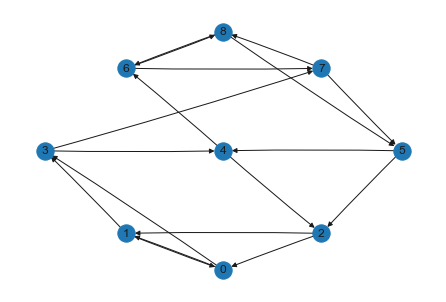

In [604]:
nx.draw(gw.G,
        pos=np.array(poke_pos),#[np.random.permutation(range(9))],
        connectionstyle='arc3, rad=0.01',
        with_labels=True)

In [599]:
np.array(poke_pos)

array([[149,   0],
       [ 68,  19],
       [ 68,  19],
       [  0,  62],
       [149,  62],
       [298,  62],
       [ 68, 105],
       [231, 105],
       [149, 124]])

In [285]:
gw.edge_transitions

array([[1, 3],
       [0, 3],
       [0, 1],
       [4, 7],
       [2, 6],
       [2, 4],
       [7, 8],
       [5, 8],
       [6, 5]])

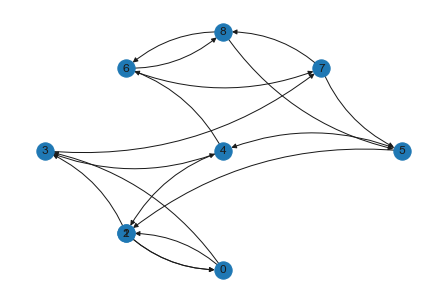

In [598]:
nx.draw(gw.G,
        pos=np.array(poke_pos),#[np.random.permutation(range(9))],
        connectionstyle='arc3, rad=0.2',
        with_labels=True)

In [481]:
p0 = poke_posN[6].astype('float')
p1 = poke_posN[4].astype('float')
p2 = poke_posN[0].astype('float')

In [482]:
def angle_between(e1,c,e2):

    ba = e1 - c
    bc = e2 - c

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

In [483]:
angle_between(p0,p1,p2)

153.434948822922

In [436]:
np.dot(p0,p1)

-4.0

In [437]:
np.dot(p0,p1)

-4.0

In [438]:
poke_posN

array([[ 0,  4],
       [-1,  2],
       [ 1,  2],
       [-2,  0],
       [ 0,  0],
       [ 2,  0],
       [-1, -2],
       [ 1, -2],
       [ 0, -4]])

In [440]:
np.arccos(np.dot(p0,p1)/(np.linalg.norm(p0)*np.linalg.norm(p1)))/np.pi

1.0

In [490]:
inputs = np.where(gw.edge_transitions==6)[0]
outputs = gw.edge_transitions[6]

In [495]:
inputs

array([4, 8])

In [518]:
out,out2 = find_number_of_turnarounds(gw.edge_transitions,poke_pos)

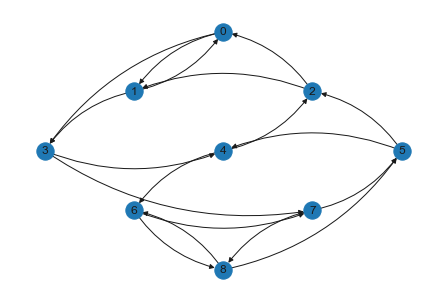

In [520]:
nx.draw(gw.G,
        pos=np.array(poke_pos),#[np.random.permutation(range(9))],
        connectionstyle='arc3, rad=0.2',
        with_labels=True)

In [524]:
out2[:8]

[[1, 0, 1],
 [1, 0, 3],
 [2, 0, 1],
 [2, 0, 3],
 [0, 1, 0],
 [0, 1, 3],
 [2, 1, 0],
 [2, 1, 3]]

In [525]:
np.mean(np.array(out)<90)

0.6111111111111112

In [517]:
def find_number_of_turnarounds(edge_transitions,pos):
    """ This function takes in the edges of the graph as well as the physical position of
        the nodes and find out how often mice need to change physical direction
    """
    
    nNodes = len(pos)
    
    paths = []
    for node in range(nNodes):
        
        outputs = edge_transitions[node]             #these are nodes that node proejcts to
        inputs = np.where(gw.edge_transitions==node)[0] #these are nodes that project to node 
        
        paths = paths + [[i,node,j] for i in inputs for j in outputs]

    all_angles = []
    for p in paths:
        e1,c,e2 = p
        all_angles.append(angle_between(pos[e1],pos[c],pos[e2]))

    
    return np.array(all_angles),np.array(paths)

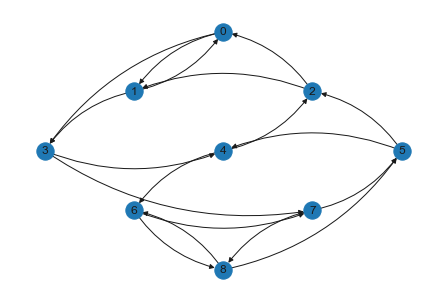

In [292]:
nx.draw(gw.G,
        pos=np.array(poke_pos),#[np.random.permutation(range(9))],
        connectionstyle='arc3, rad=0.2',
        with_labels=True)

In [555]:
import random

In [567]:
np.array([[None,None] for _ in range(5)]).shape

(5, 2)

In [571]:
for a,b in [[1,2],[2,3]]:
    print(a,b)

1 2
2 3


In [578]:
def get_transition_set(links,nStates=9):
    """ Takes as input the list of edges and edges and returns an array 
        that gives the transitions available as a function of state
    """
    edge_set = [[None,None] for _ in range(nStates)]#np.zeros([self.nNodes,self.nActions],dtype='int')
    cntArr = [0]*nStates#np.zeros(self.nNodes,dtype='int')
    for fst,snd in links:
        edge_set[fst][cntArr[fst]] = snd
        cntArr[fst] += 1
    return edge_set


In [580]:
gw.edge_transitions

array([[1, 3],
       [0, 3],
       [0, 1],
       [4, 7],
       [2, 6],
       [2, 4],
       [7, 8],
       [5, 8],
       [6, 5]])

In [579]:
get_transition_set(gw.edges)

[[1, 3], [0, 3], [0, 1], [4, 7], [2, 6], [2, 4], [7, 8], [5, 8], [6, 5]]

4945
(0, 2, 5, 7)
[1, 3, 3, 2]
9.0


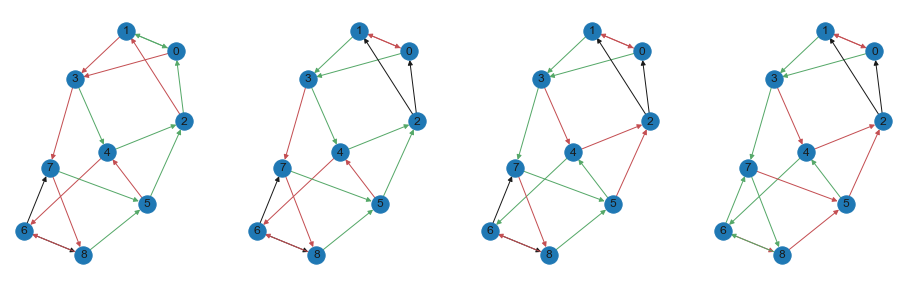

In [243]:
plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][0],pos=nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,2)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][1],pos=nx.nx.layout.kamada_kawai_layout(gw.G))


plt.subplot(1,4,3)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][2],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,4)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][3],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

print(np.argmax(diffStore))
print(possible_reward_locations[allV[np.argmax(diffStore)][1]])
print(allLD[np.argmax(diffStore)][-1])
print(diffStore[np.argmax(diffStore)])

342
(1, 6, 7, 8)
[1, 2, 2, 2]


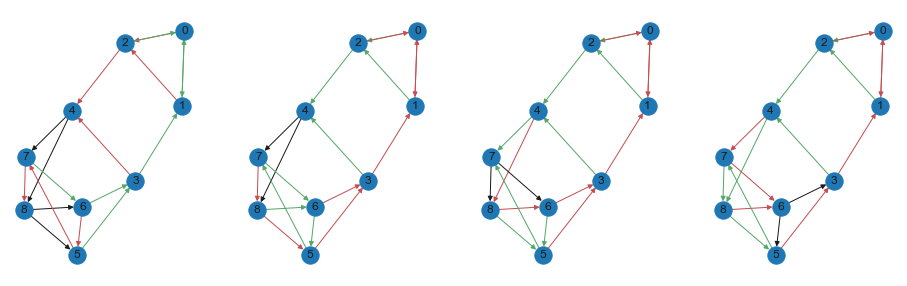

In [219]:
plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][0],pos=nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,2)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][1],pos=nx.nx.layout.kamada_kawai_layout(gw.G))


plt.subplot(1,4,3)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][2],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,4)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][3],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

print(np.argmax(diffStore))
print(possible_reward_locations[allV[np.argmax(diffStore)][1]])
print(allLD[np.argmax(diffStore)][-1])
#print(diffStore[np.argmax(diffStore)])

1358
(2, 3, 6, 7)
[2, 2, 2, 2]
7.0


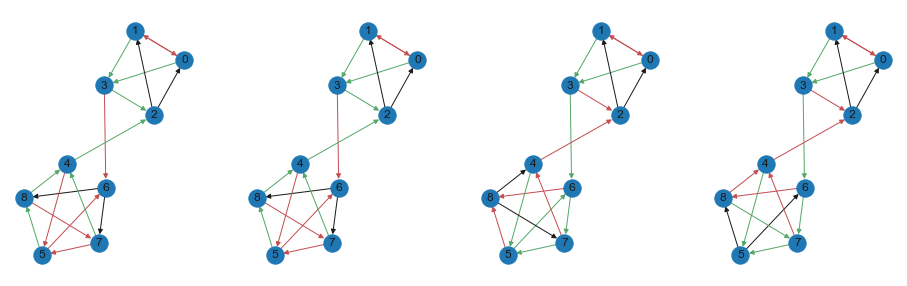

In [204]:
plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][0],pos=nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,2)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][1],pos=nx.nx.layout.kamada_kawai_layout(gw.G))


plt.subplot(1,4,3)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][2],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

plt.subplot(1,4,4)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][3],pos=nx.nx.layout.kamada_kawai_layout(gw.G))

print(np.argmax(diffStore))
print(possible_reward_locations[allV[np.argmax(diffStore)][1]])
print(allLD[np.argmax(diffStore)][-1])
#print(diffStore[np.argmax(diffStore)])

/Users/Yves/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


(2, 3, 5, 7)


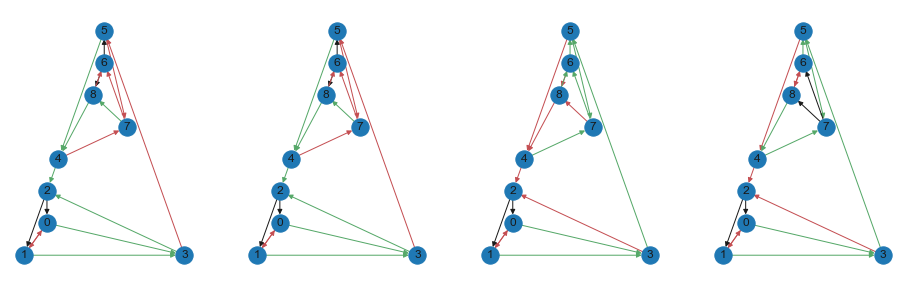

In [182]:
plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][0],pos=nx.planar_layout(gw.G))

plt.subplot(1,4,2)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][1],pos=nx.planar_layout(gw.G))


plt.subplot(1,4,3)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][2],pos=nx.planar_layout(gw.G))

plt.subplot(1,4,4)
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][3],pos=nx.planar_layout(gw.G))

print(possible_reward_locations[allV[np.argmax(diffStore)][1]])

/Users/Yves/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


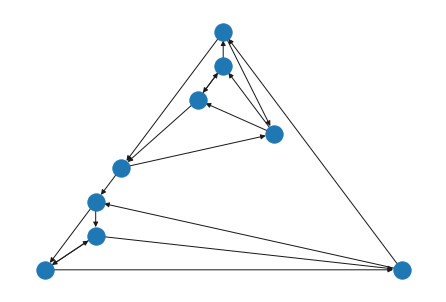

In [177]:
nx.draw(gw.G,pos=nx.planar_layout(gw.G))

In [172]:
G2 = nx.algorithms.planarity.check_planarity(gw.G)[1]

In [173]:
G2.add_edges_from(gw.edges)

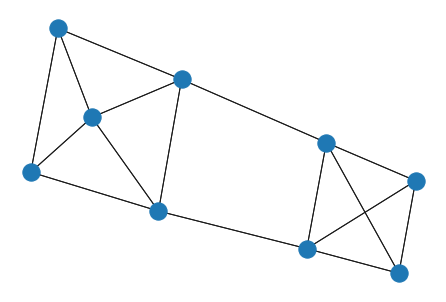

In [175]:
nx.draw(G2)

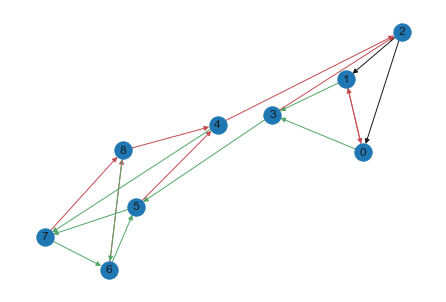

In [161]:
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][2])

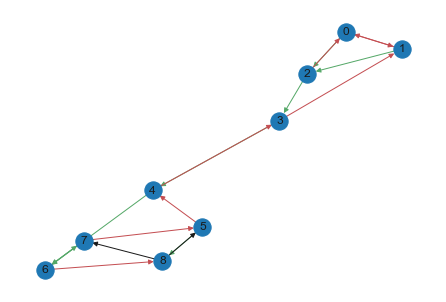

In [45]:
gw.plot_policy_onto_graph(allP[np.argmax(diffStore)][-1][3])

In [41]:
allP[np.argmax(diffStore)][-1]

[array([[0.5, 0.5],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ]]), array([[0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ]]), array([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]), array([[1. , 0. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5]])]

In [ ]:
graph_ix = 3


In [137]:
pdist(np.array(allP[0][-1]).reshape(4,-1))

array([1.        , 1.73205081, 2.23606798, 1.73205081, 2.23606798,
       1.        ])

In [133]:
np.array(allP[0][-1]).reshape(4,-1)

array([[0.5, 0.5, 1. , 0. , 1. , 0. , 1. , 0. , 1. , 0. , 1. , 0. , 0.5,
        0.5, 1. , 0. , 1. , 0. ],
       [0. , 1. , 0.5, 0.5, 1. , 0. , 1. , 0. , 1. , 0. , 1. , 0. , 0.5,
        0.5, 1. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 1. , 0.5, 0.5, 1. , 0. , 1. , 0. , 1. , 0. , 0.5,
        0.5, 1. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 1. , 0. , 1. , 0.5, 0.5, 1. , 0. , 1. , 0. , 0.5,
        0.5, 1. , 0. , 1. , 0. ]])

In [114]:
aat = [1,2,3]

In [ ]:
V.copy

In [746]:
def value_iteration_slow(gw,gamma = 0.9):
    
    V = np.zeros(gw.n_states)
    for s in range(gw.n_states):
        Vprev = V.copy()

        if s not in gw.terminal_states:
            tmp = []
            tmpT_ = []
            for a in range(2):
                t_ = gw.edge_transitions[s,a]
                v_ = gw.rewards[t_] + gamma*Vprev[t_]
                tmp.append(v_)
            V[s] = np.max(tmp)
    return V

In [ ]:
allLD = []
for graph_ix in list(set(graph_indices)):
    #sys.s
    gw = gt.graphworld(all_graphs[graph_ix])
    for rew_locs in possible_reward_locations:
        tmp = []
        for r in rew_locs:
            gw.set_reward_state(r)    
            tmp.append(gt.optimize.find_shortest_reward_loop(gw).copy())
            
        allLD.append(tmp)
allLD = np.array(allLD)
np.save(os.path.join(ROOT,'rew_loop_lens.npy'),allLD)